# Feature Extraction

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

Load image as greyscale, display image.

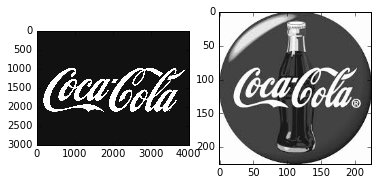

In [5]:
imgRef = cv2.imread('./Data/Reference/1.jpg', 0) #1 is colour, 0 is greyscale, -1 is unchanged
imgTest = cv2.imread('./Data/Test/1.jpg', 0)
#print imgRef
#plt.imshow(imgRef) #??? Why such a strange colour???

fig = plt.figure()
plt.subplot(121)
plt.imshow(imgRef, cmap='gray')
plt.subplot(122)
plt.imshow(imgTest, cmap='gray')
plt.show()

## ORB (Oriented FAST and Rotated BRIEF)

In [6]:
cv2.ocl.setUseOpenCL(False) # this is a temporary solution, see https://github.com/opencv/opencv/issues/6081
orb = cv2.ORB_create() # cv2.ORB_create() is for opencv3
#orb = cv2.ORB() # cv2.ORB() is opencv2

#detect key points
kpRef, descRef = orb.detectAndCompute(imgRef, None)
kpTest, descTest = orb.detectAndCompute(imgTest, None)

Draw key points detected.

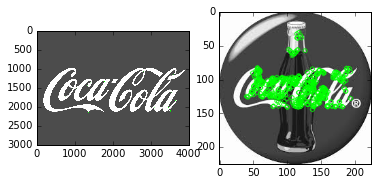

In [7]:
# draw only keypoints location,not size and orientation
# imgRef_kp = cv2.drawKeypoints(imgRef,kpRef,color=(0,255,0), flags=0) # opencv2
# imgTest_kp = cv2.drawKeypoints(imgTest,kpTest,color=(0,255,0), flags=0) #opencv2

imgRef_kp = cv2.drawKeypoints(imgRef, kpRef, outImage=None, color=(0,255,0), flags=0)
imgTest_kp = cv2.drawKeypoints(imgTest, kpTest, outImage=None, color=(0,255,0), flags=0)

fig = plt.figure()
plt.subplot(121)
plt.imshow(imgRef_kp)
plt.subplot(122)
plt.imshow(imgTest_kp)
plt.show()

In [23]:
#cv2.drawKeypoints?

## Brute Force Matching

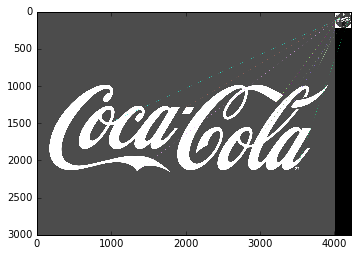

In [8]:
# create a BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descRef, descTest) # can try bf.knnMatch()

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
imgResult = cv2.drawMatches(imgRef,kpRef,imgTest,kpTest,matches[:10], outImg=None, flags=2)
# The line above will not work, as cv2 has no drawMatches. 

plt.imshow(imgResult)
plt.show()

In [17]:
FLANN_INDEX_LSH = 0; # ???What should the value be???
index_params= dict(algorithm = FLANN_INDEX_LSH, 
                    table_number = 6, # 12
                    key_size = 12,     # 20
                    multi_probe_level = 1) #2

search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(descRef, descTest, k=3) 
# TODO: The fix for the line above: https://github.com/opencv/opencv/issues/5667, need to rebuild.


# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in xrange(len(matches))]

 # ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                    singlePointColor = (255,0,0),
                    matchesMask = matchesMask,
                    flags = 0)
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()

error: C:\builds\master_PackSlaveAddon-win64-vc12-static\opencv\modules\python\src2\cv2.cpp:163: error: (-215) The data should normally be NULL! in function NumpyAllocator::allocate


### Section Below is specific to opencv 2.x

### drawMatches
cv2.drawMatches will not work, as cv2 has no such module. See below for workround found at openstack by `rayryeng`


In [ ]:
import numpy as np
import cv2

def drawMatches(img1, kp1, img2, kp2, matches):
    """
    My own implementation of cv2.drawMatches as OpenCV 2.4.9
    does not have this function available but it's supported in
    OpenCV 3.0.0

    This function takes in two images with their associated 
    keypoints, as well as a list of DMatch data structure (matches) 
    that contains which keypoints matched in which images.

    An image will be produced where a montage is shown with
    the first image followed by the second image beside it.

    Keypoints are delineated with circles, while lines are connected
    between matching keypoints.

    img1,img2 - Grayscale images
    kp1,kp2 - Detected list of keypoints through any of the OpenCV keypoint 
              detection algorithms
    matches - A list of matches of corresponding keypoints through any
              OpenCV keypoint matching algorithm
    """

    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1,:] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:cols1+cols2,:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)


    # Show the image
    cv2.imshow('Matched Features', out)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Now, let's try again with the function above.

In [ ]:
# create a BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descRef, descTest) # can try bf.knnMatch()
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

In [ ]:
# Draw first 10 matches.
drawMatches(imgRef,kpRef,imgTest,kpTest,matches[:10])